# Final Presentation

## Data Analysis Mathematics, Algorithms and Modeling

## $TRUMP - Sentiment Analysis

### Team Members:

### Eris Leksi - 9067882

### Fasalu Rahman Kottaparambu - 8991782

### Kapil Bhardwaj - 9064347

## Project Overview

This project investigates the impact of news and social media sentiment on the price movements of the $TRUMP cryptocurrency token, in comparison with major coins including Bitcoin (BTC), Ethereum (ETH), Chainlink (LINK), and Dogecoin (DOGE). The goal is to understand and model how sentiment-driven signals, combined with historical price data, affect short-term price dynamics in both meme/political and established cryptocurrencies.

## Data Sources

- **Cryptocurrency price data:** Sourced via the AlphaVantage API (daily historical OHLCV for all selected coins).
- **Sentiment data:** Sourced via the Alternative.me Crypto Fear & Greed Index (Free API).
## Key Objectives

- Explore and visualize the relationship between sentiment signals and price action.
- Engineer features that combine historical price behavior with external sentiment.
- Build, evaluate, and compare machine learning and deep learning models for price prediction.
- Make short-term predictions for each coin, and discuss performance, interpretability, and relevance to real-world crypto trading and risk.

### Importing the necessary libraries

In [74]:
# Data handling and manipulation
import pandas as pd
import numpy as np

# Date/time handling
from datetime import datetime, timedelta

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# API requests
import requests
import time

# Machine Learning models
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from scipy.stats import ttest_ind
import itertools

# Deep Learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Sentiment analysis (if you process tweets yourself)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # pip install vaderSentiment

# Suppress warnings (optional)
import warnings
warnings.filterwarnings('ignore')


### Loading the data

#### 1. Coins

In [75]:
class AlphaVantageCryptoDownloader:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"
    
    def get_daily_data(self, symbol, market='USD'):
        params = {
            "function": "DIGITAL_CURRENCY_DAILY",
            "symbol": symbol,
            "market": market,
            "apikey": self.api_key
        }
        response = requests.get(self.base_url, params=params)
        data = response.json()
        key = 'Time Series (Digital Currency Daily)'
        if key in data:
            df = pd.DataFrame(data[key]).T
            df = df.rename(columns=lambda x: x.split(". ")[1])
            df.index = pd.to_datetime(df.index)
            df = df.astype(float)
            df["coin"] = symbol
            return df
        else:
            print(f"Error for {symbol}: {data}")
            return None

# Use your provided API key
api_key = 'IC5Z69JRSVKWG8LG'
downloader = AlphaVantageCryptoDownloader(api_key)
coins = ['TRUMP', 'BTC', 'ETH', 'DOGE', 'LINK'] 

all_dfs = []
for coin in coins:
    print(f"Downloading {coin} data...")
    df = downloader.get_daily_data(coin)
    if df is not None:
        all_dfs.append(df)
    time.sleep(15)  

# Combine all coins' data
price_df = pd.concat(all_dfs).reset_index().rename(columns={'index': 'date'})
print("Combined data shape:", price_df.shape)
price_df.head()


Combined data shape: (1600, 7)


,date,open,high,low,close,volume,coin
0,2025-08-08,9.26,9.31,9.14,9.20,91657.372,TRUMP
1,2025-08-07,8.85,9.25,8.80,9.25,399920.740,TRUMP
2,2025-08-06,8.68,8.90,8.57,8.86,356115.610,TRUMP
3,2025-08-05,9.04,9.05,8.55,8.68,395310.212,TRUMP
4,2025-08-04,8.82,9.05,8.81,9.04,299052.879,TRUMP


#### 2. Sentiment Data

In [76]:
# Download the full historical Fear & Greed Index
url = "https://api.alternative.me/fng/?limit=0&format=json"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
fng_df = pd.DataFrame(data['data'])

# Clean up and format
fng_df['date'] = pd.to_datetime(fng_df['timestamp'], unit='s').dt.date
fng_df['fng_value'] = pd.to_numeric(fng_df['value'])
fng_df = fng_df[['date', 'fng_value', 'value_classification']].sort_values('date')

# Optional: rename columns for clarity
fng_df.rename(columns={
    'fng_value': 'sentiment_score',
    'value_classification': 'sentiment_label'
}, inplace=True)

fng_df.head()

,date,sentiment_score,sentiment_label
2741,2018-02-01,30,Fear
2740,2018-02-02,15,Extreme Fear
2739,2018-02-03,40,Fear
2738,2018-02-04,24,Extreme Fear
2737,2018-02-05,11,Extreme Fear


#### 3.Merging Market Sentiment with all the Crypto Price Data

In [77]:
# Ensure date columns match in type
price_df['date'] = pd.to_datetime(price_df['date']).dt.date
fng_df['date'] = pd.to_datetime(fng_df['date']).dt.date

# Merge the sentiment onto every row (for all coins)
merged_df = pd.merge(price_df, fng_df, on='date', how='left')

print(f"Data shape after merging sentiment: {merged_df.shape}")
merged_df[['date', 'coin', 'close', 'sentiment_score', 'sentiment_label']].head()


Data shape after merging sentiment: (1600, 9)


,date,coin,close,sentiment_score,sentiment_label
0,2025-08-08,TRUMP,9.20,74.0,Greed
1,2025-08-07,TRUMP,9.25,62.0,Greed
2,2025-08-06,TRUMP,8.86,54.0,Neutral
3,2025-08-05,TRUMP,8.68,60.0,Greed
4,2025-08-04,TRUMP,9.04,64.0,Greed


### Exploratory Data Analysis (EDA)

#### 1. Plotting Closing Price over time

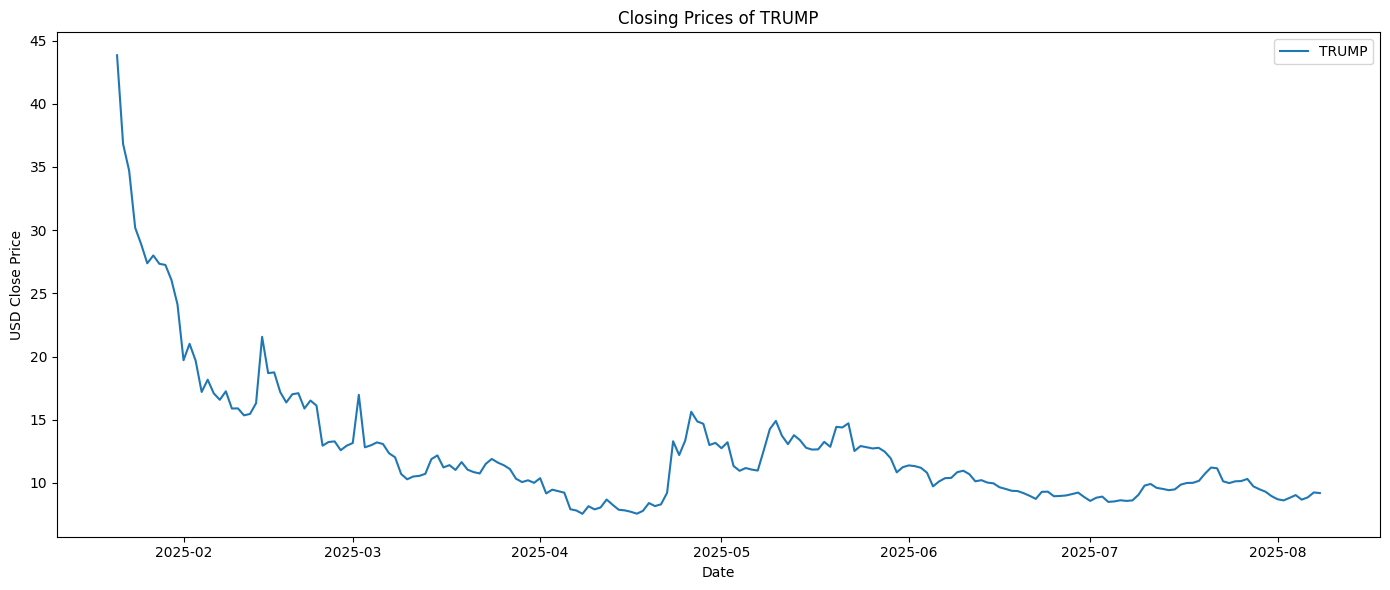

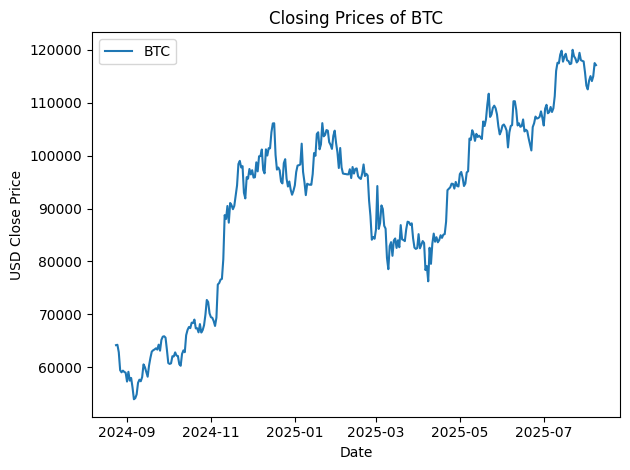

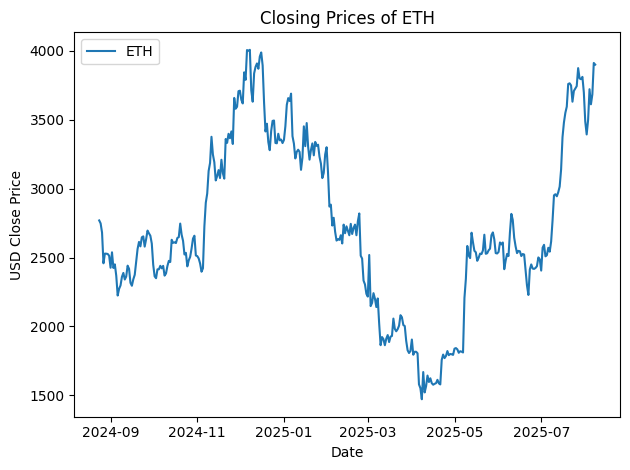

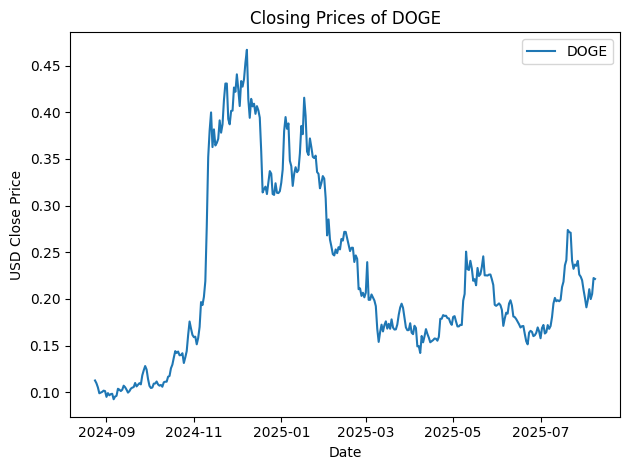

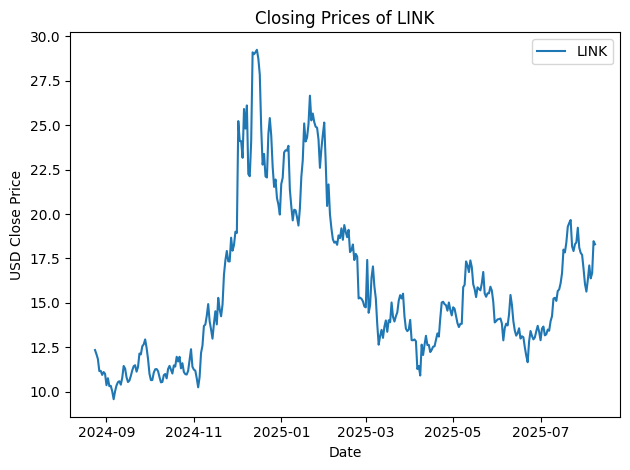

In [78]:
plt.figure(figsize=(14, 6))
for coin in merged_df['coin'].unique():
    data = merged_df[merged_df['coin'] == coin]
    plt.plot(data['date'], data['close'], label=coin)
    plt.title(f"Closing Prices of {coin}")
    plt.xlabel("Date")
    plt.ylabel("USD Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

Here we plot the daily closing price for each cryptocurrency to see how their values have changed over time. This helps us spot major price moves, trends, and differences between the coins at a glance.

#### 2. Market Sentiment over time

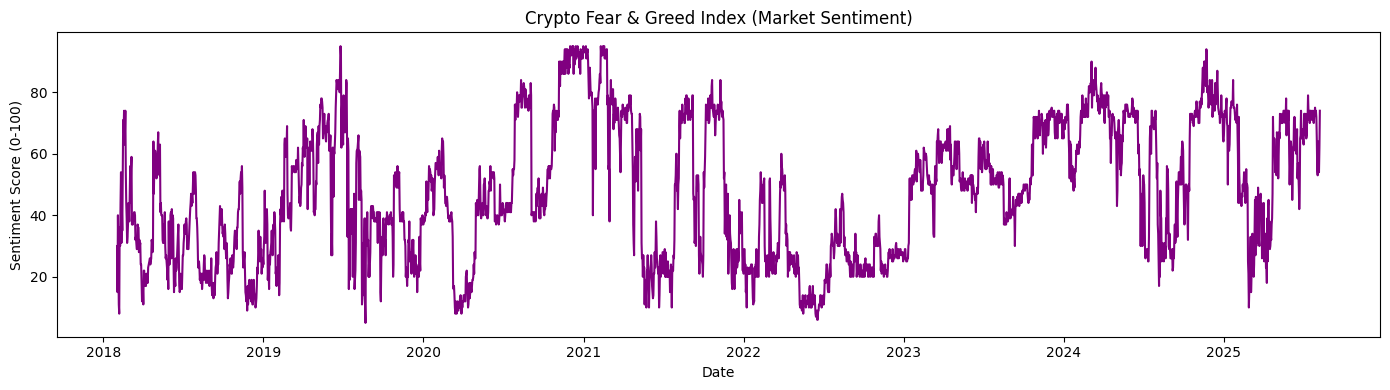

In [79]:
plt.figure(figsize=(14, 4))
plt.plot(fng_df['date'], fng_df['sentiment_score'], color='purple')
plt.title("Crypto Fear & Greed Index (Market Sentiment)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (0-100)")
plt.tight_layout()
plt.show()

This plot shows how the overall crypto market sentiment has changed over time, based on the Fear & Greed Index. Higher scores mean more greed or optimism, while lower scores mean more fear.


#### 3. Distribution of sentiment labels

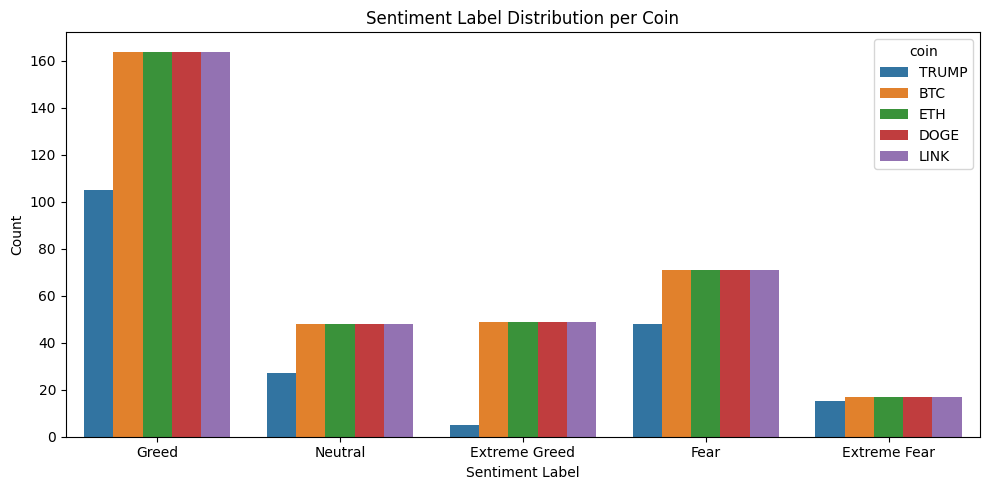

In [80]:
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment_label', hue='coin', data=merged_df)
plt.title("Sentiment Label Distribution per Coin")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We’re looking at how often each sentiment label—like "fear" or "greed"—appears for each coin. This helps us see if some coins are more often linked with positive or negative market sentiment.


#### 4. Histogram for the distribution of closing prices

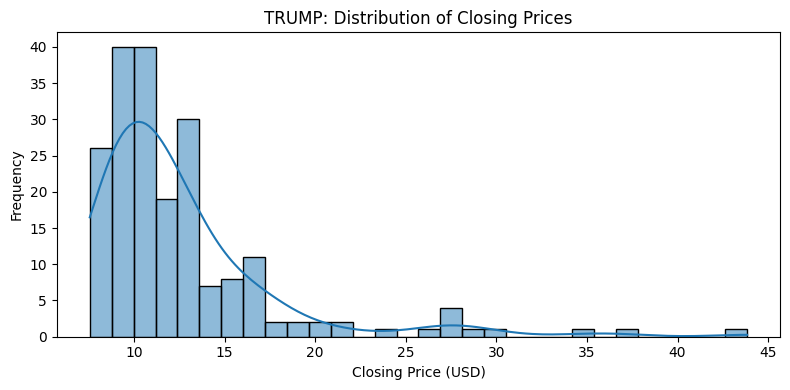

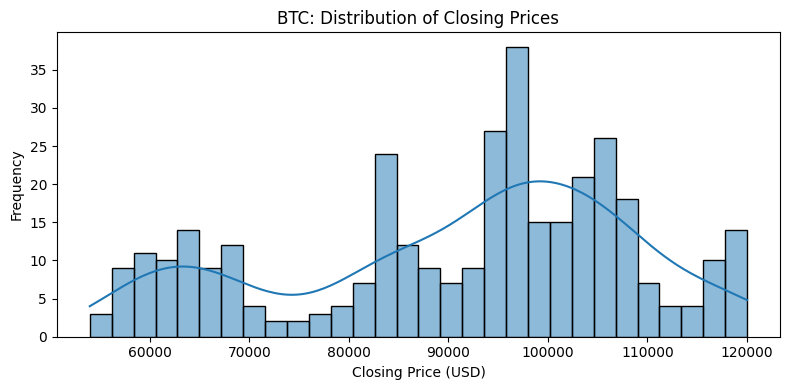

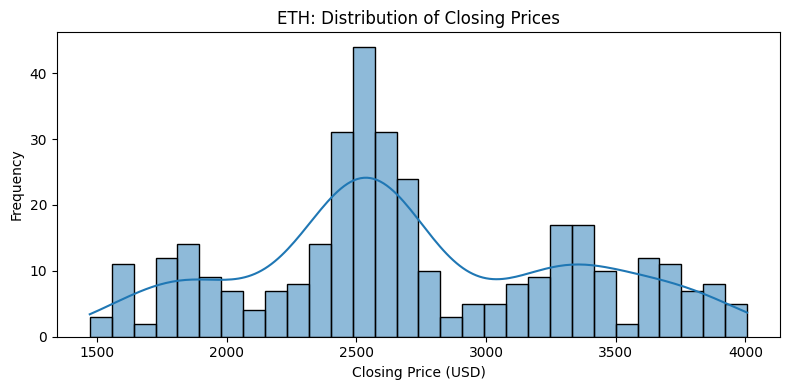

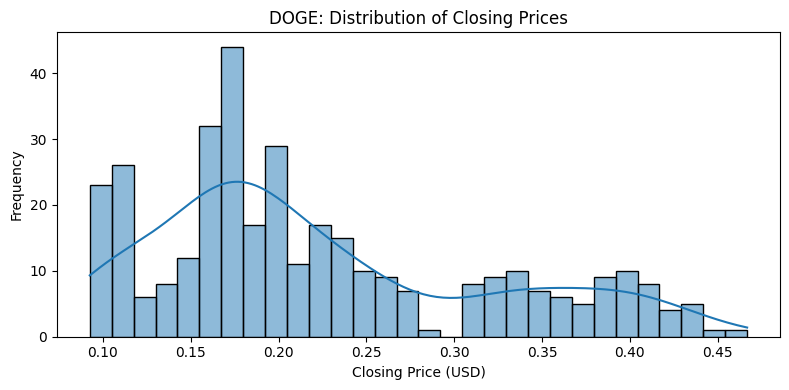

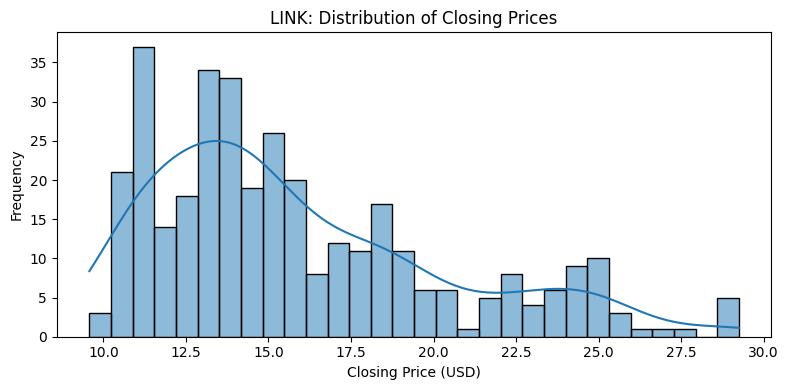

In [81]:
for coin in merged_df['coin'].unique():
    plt.figure(figsize=(8,4))
    sns.histplot(merged_df[merged_df['coin'] == coin]['close'], bins=30, kde=True)
    plt.title(f'{coin}: Distribution of Closing Prices')
    plt.xlabel('Closing Price (USD)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Here we’re checking the distribution of closing prices for each coin. This gives us a feel for their typical price ranges and whether any values are unusually high or low.


#### 5. Histogram for the distribution of the sentiment scores

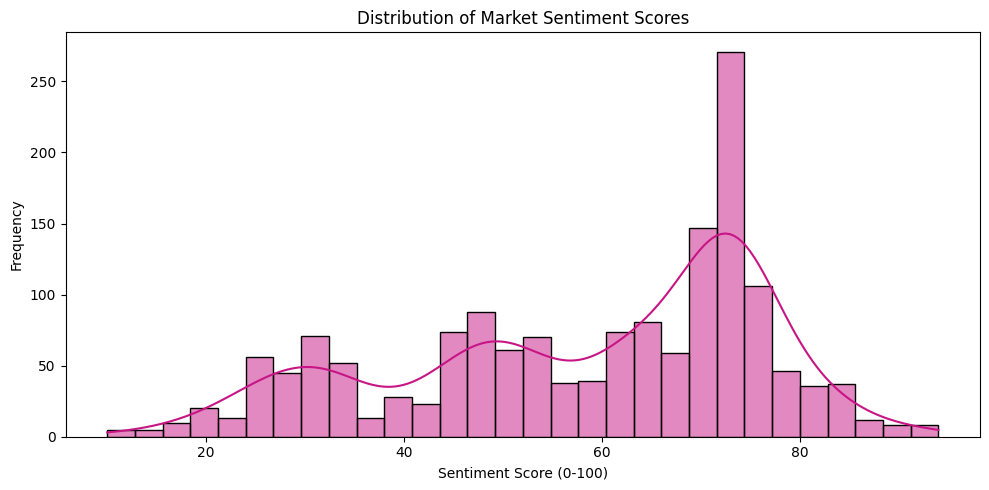

In [82]:
plt.figure(figsize=(10,5))
sns.histplot(merged_df['sentiment_score'], bins=30, kde=True, color='mediumvioletred')
plt.title('Distribution of Market Sentiment Scores')
plt.xlabel('Sentiment Score (0-100)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

This plot shows how the market sentiment scores are spread out over time. We can see if the market has been feeling mostly fearful, greedy, or somewhere in between.


#### 6. Boxplot of closing price by month per coin

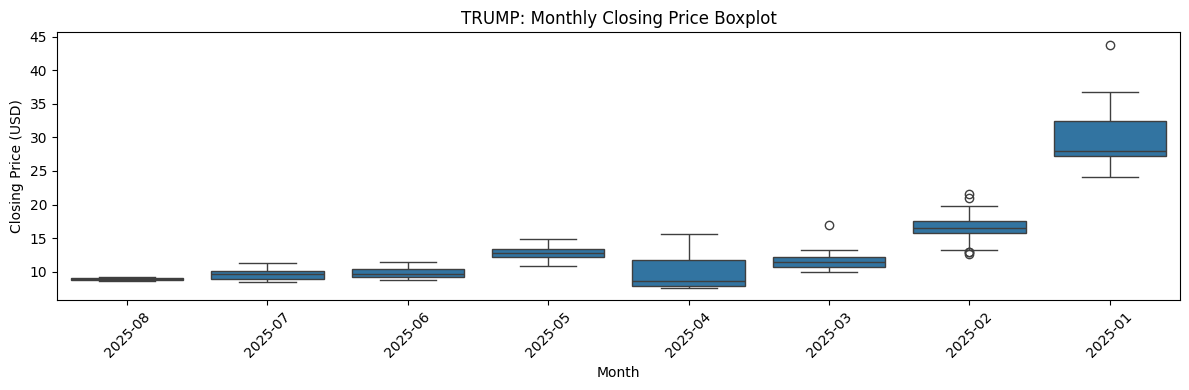

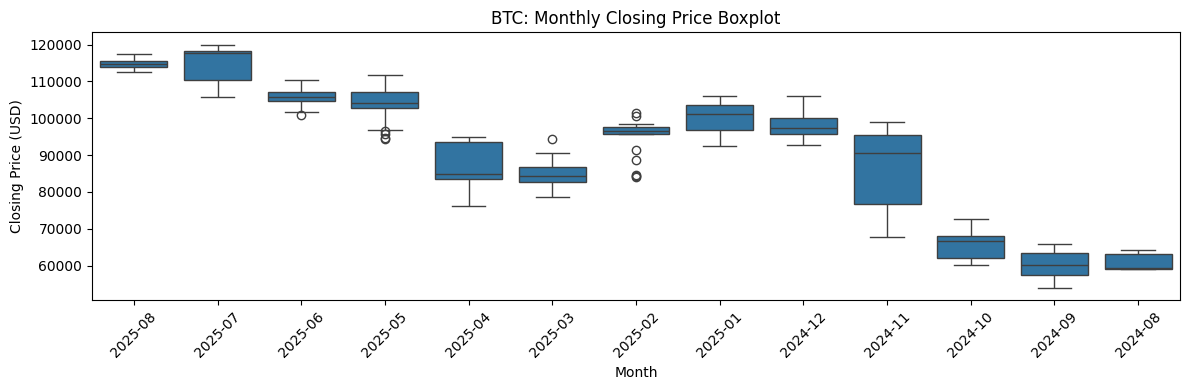

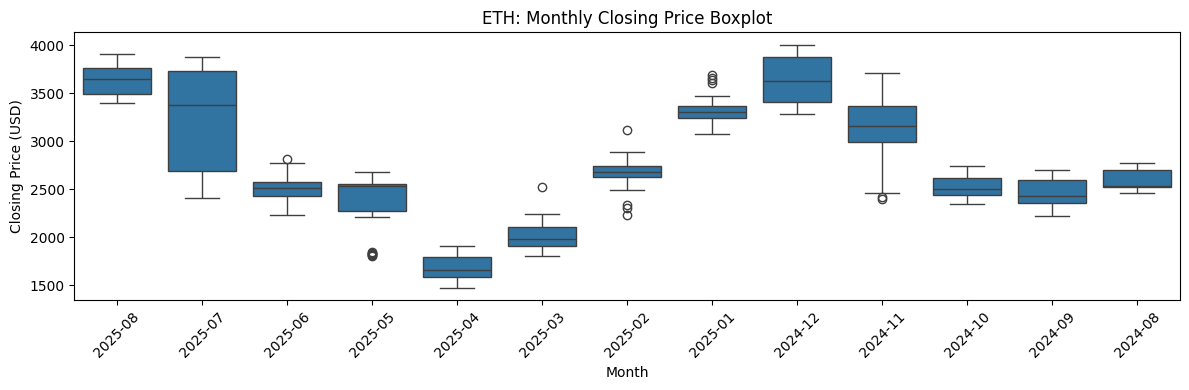

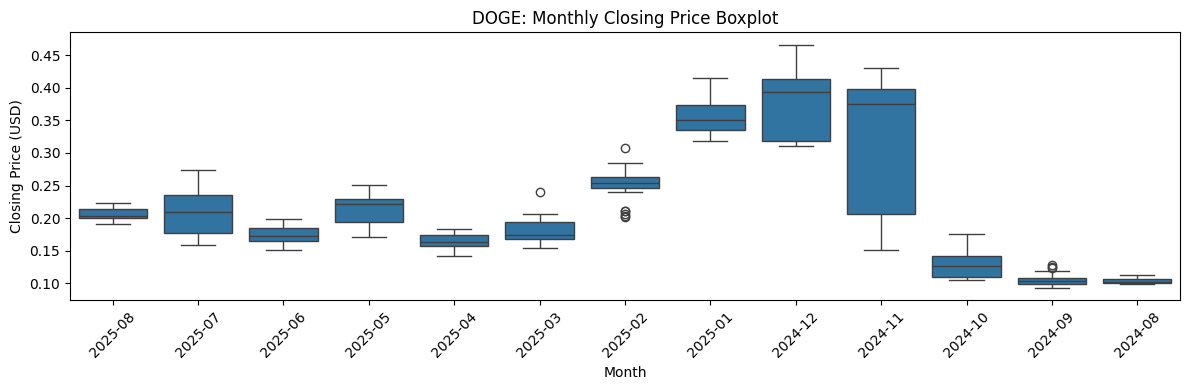

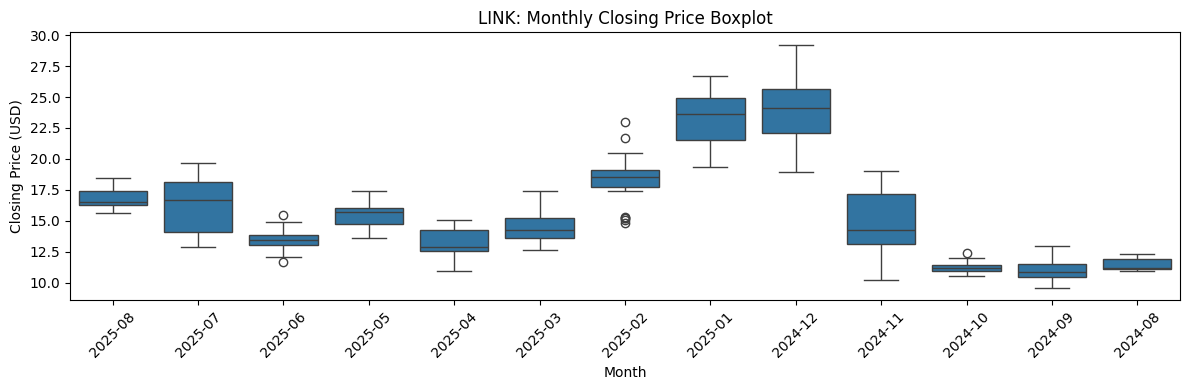

In [83]:
for coin in merged_df['coin'].unique():
    coin_data = merged_df[merged_df['coin'] == coin].copy()
    coin_data['month'] = pd.to_datetime(coin_data['date']).dt.to_period('M')
    plt.figure(figsize=(12,4))
    sns.boxplot(x='month', y='close', data=coin_data)
    plt.title(f'{coin}: Monthly Closing Price Boxplot')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

We’re using boxplots to see how each coin’s closing prices vary from month to month. This makes it easy to spot periods with lots of price swings or outliers.


#### 7. Sentiment over time per coin

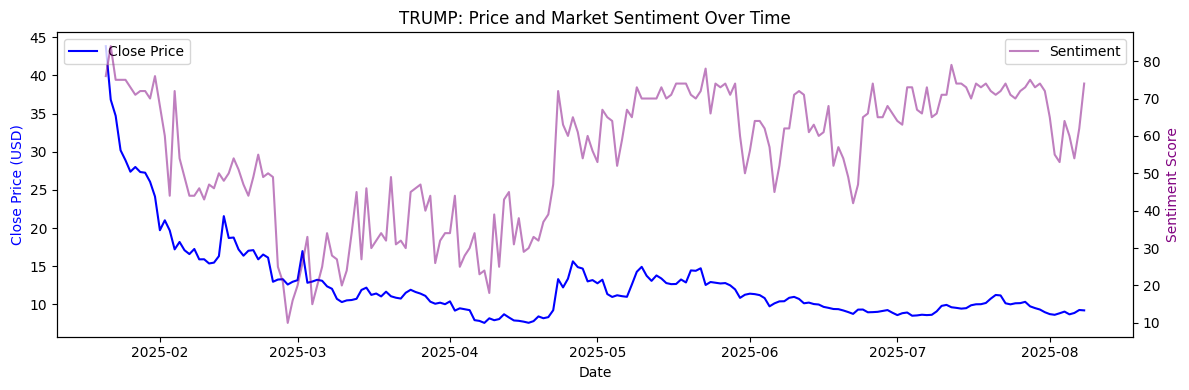

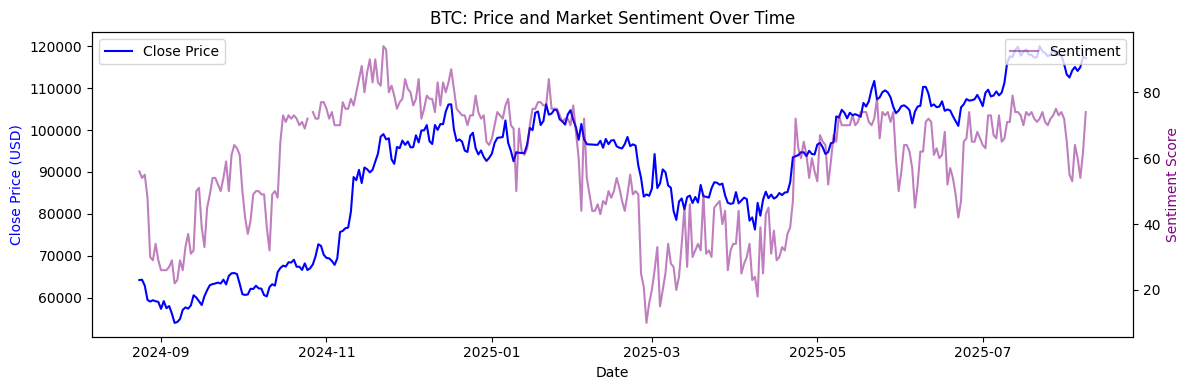

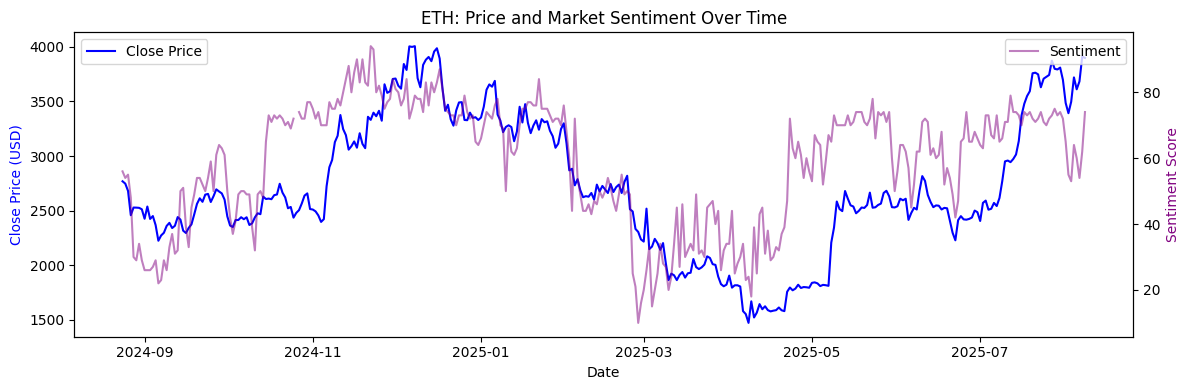

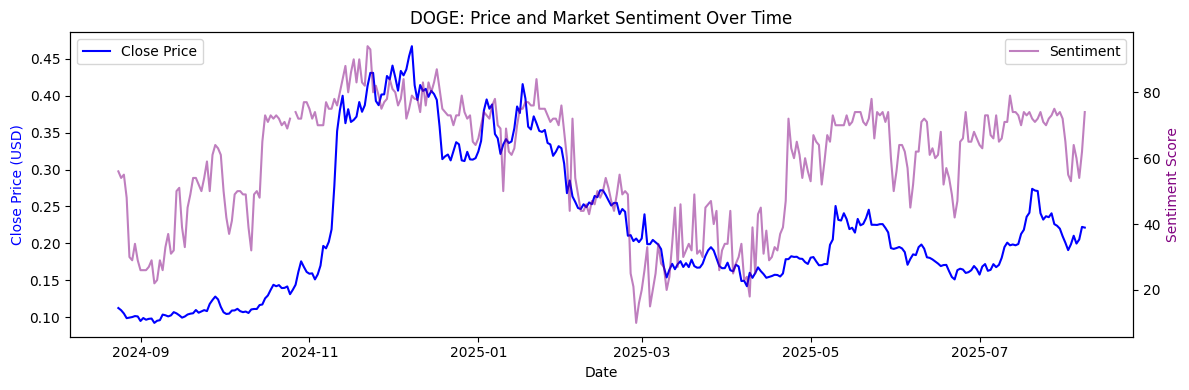

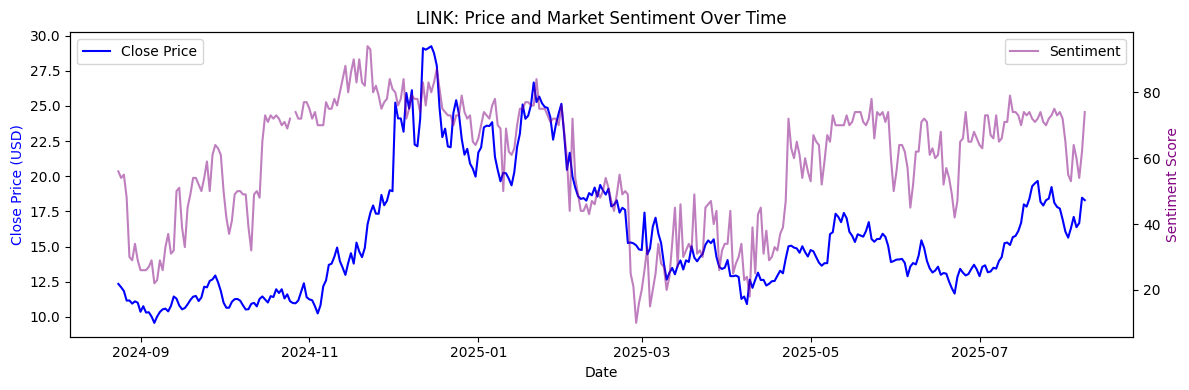

In [84]:
for coin in merged_df['coin'].unique():
    coin_data = merged_df[merged_df['coin'] == coin].copy()
    fig, ax1 = plt.subplots(figsize=(12,4))
    ax2 = ax1.twinx()
    ax1.plot(coin_data['date'], coin_data['close'], color='b', label='Close Price')
    ax2.plot(coin_data['date'], coin_data['sentiment_score'], color='purple', label='Sentiment', alpha=0.5)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price (USD)', color='b')
    ax2.set_ylabel('Sentiment Score', color='purple')
    plt.title(f'{coin}: Price and Market Sentiment Over Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    fig.tight_layout()
    plt.show()

We’re comparing each coin’s price and market sentiment over time on the same chart. This lets us see if big price moves match up with changes in overall market mood.


#### 8. Vioin Plot for Closing Price distribution per coin

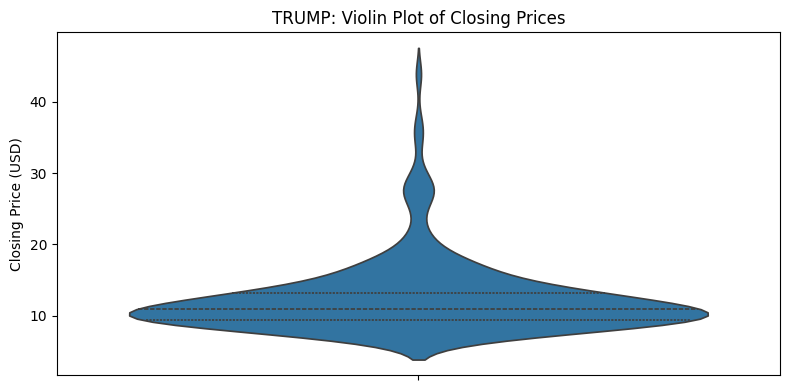

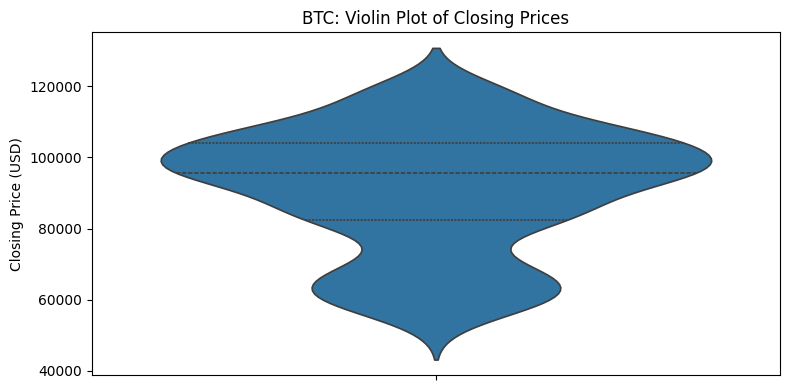

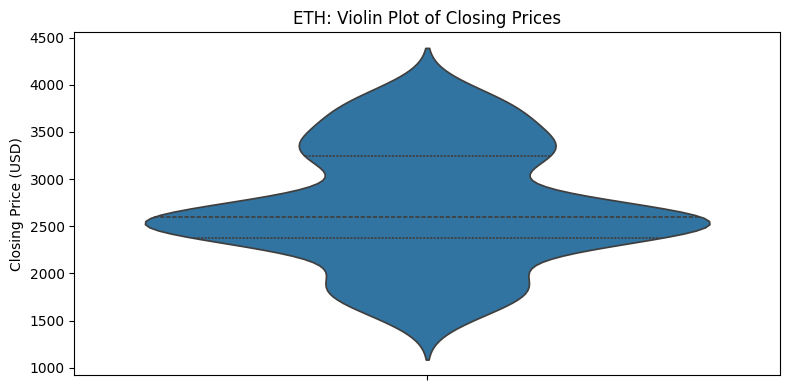

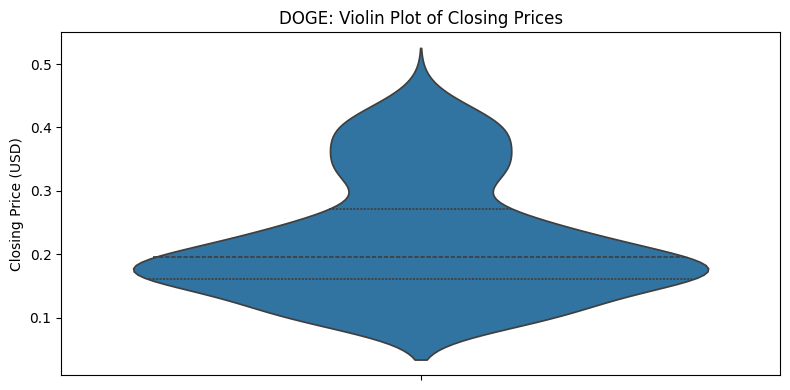

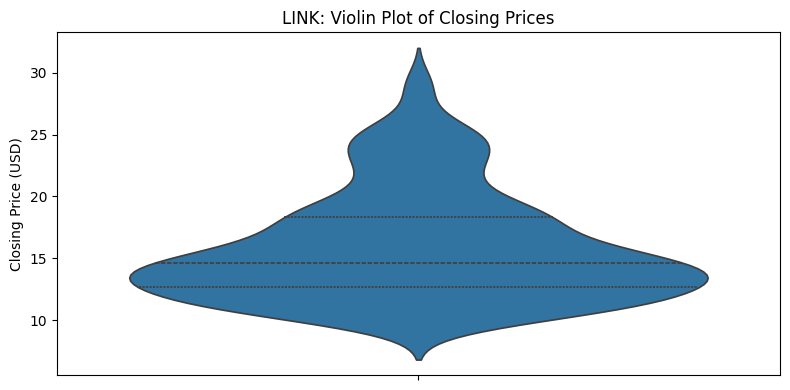

In [85]:
for coin in merged_df['coin'].unique():
    plt.figure(figsize=(8,4))
    sns.violinplot(y=merged_df[merged_df['coin'] == coin]['close'], inner='quartile')
    plt.title(f'{coin}: Violin Plot of Closing Prices')
    plt.ylabel('Closing Price (USD)')
    plt.tight_layout()
    plt.show()

The violin plot for each coin shows how its closing prices are spread out over the full dataset. The wider parts of the plot represent price ranges where the coin traded most often, while the thinner parts and “tails” show less common prices or outliers. The white dot marks the median closing price, and the thicker bar inside shows where the middle 50% of prices are. This plot makes it easy to spot if a coin usually stays in a certain price range, or if it often swings to extremes.


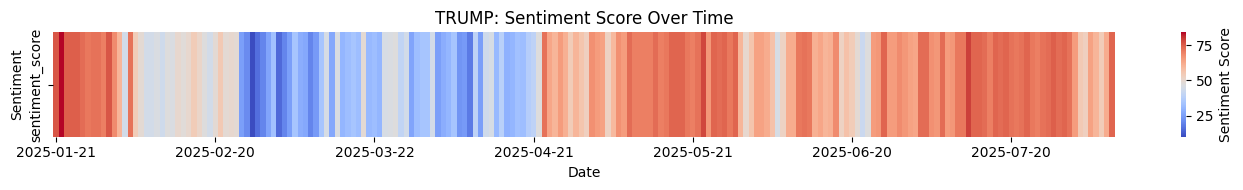

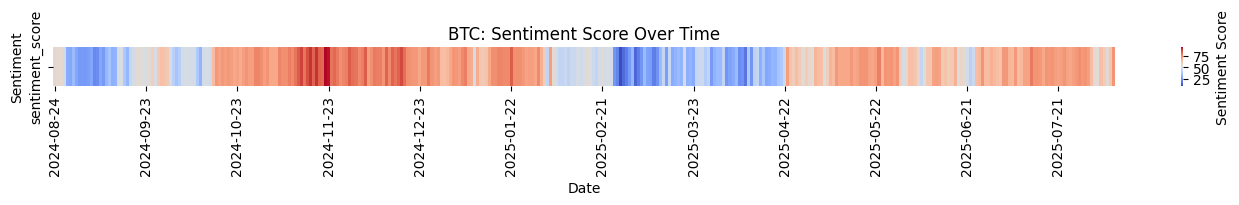

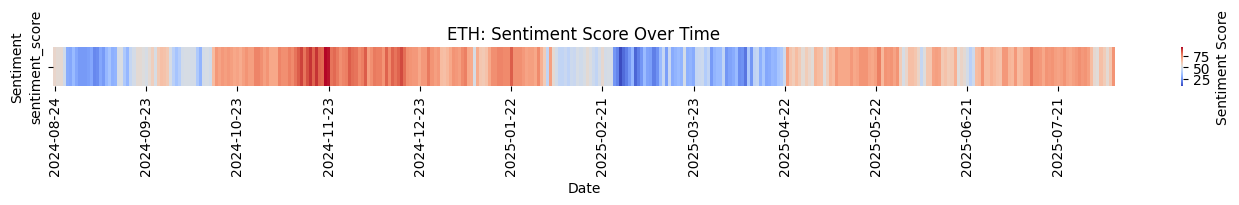

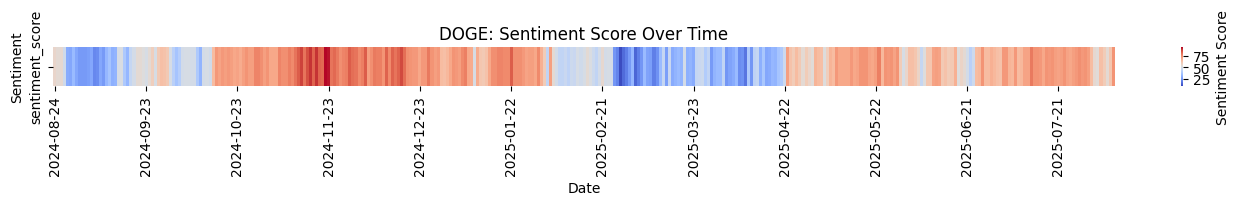

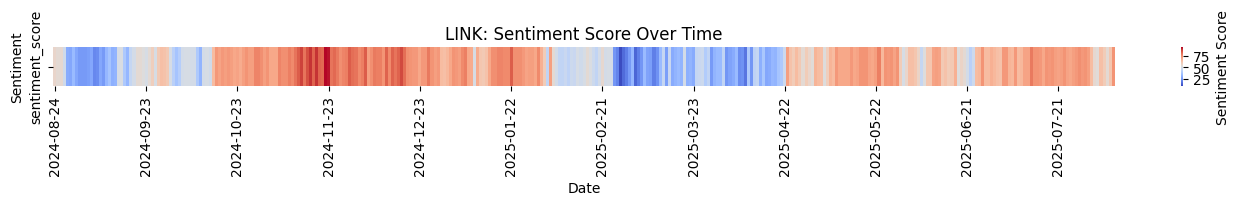

In [86]:
for coin in merged_df['coin'].unique():
    coin_data = merged_df[merged_df['coin'] == coin].copy()
    pivot = coin_data.pivot_table(
        index='date',
        values='sentiment_score'
    )
    plt.figure(figsize=(14,2))
    sns.heatmap(pivot.T, cmap='coolwarm', cbar_kws={'label': 'Sentiment Score'}, xticklabels=30)
    plt.title(f'{coin}: Sentiment Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.tight_layout()
    plt.show()


This heatmap shows how the market sentiment score changes day by day for each coin. Each vertical slice represents one day, and the color shows how positive or negative the sentiment was—red means fear, blue means greed or optimism. By looking at the color patterns, we can quickly spot periods of high excitement or worry in the market for each coin.


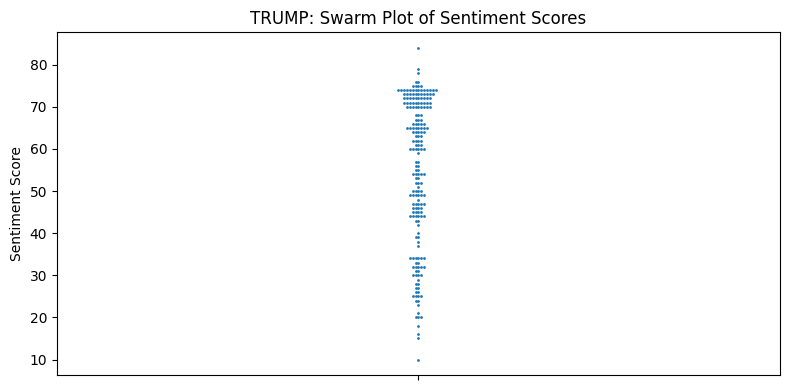

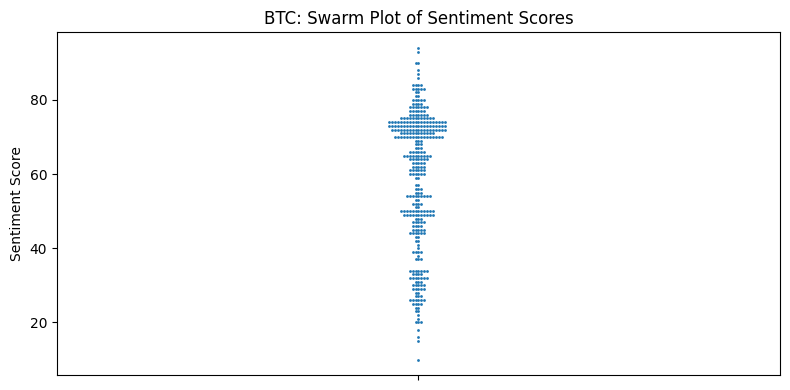

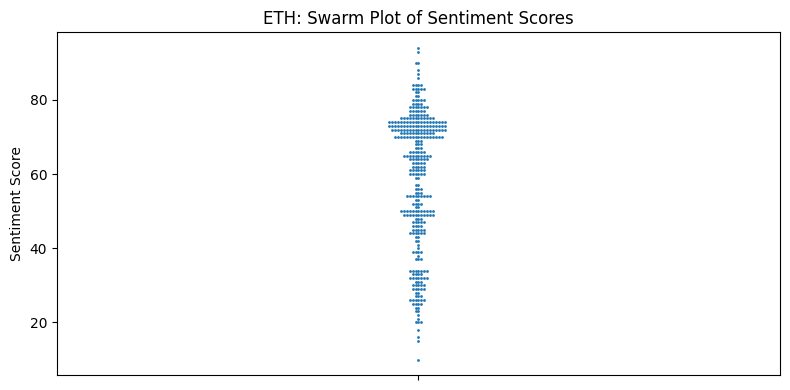

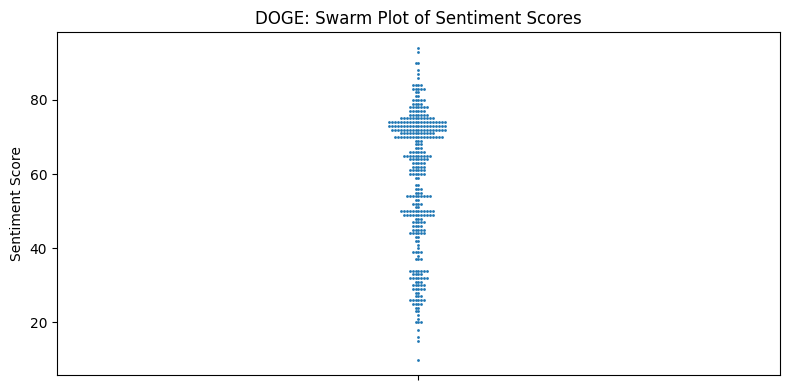

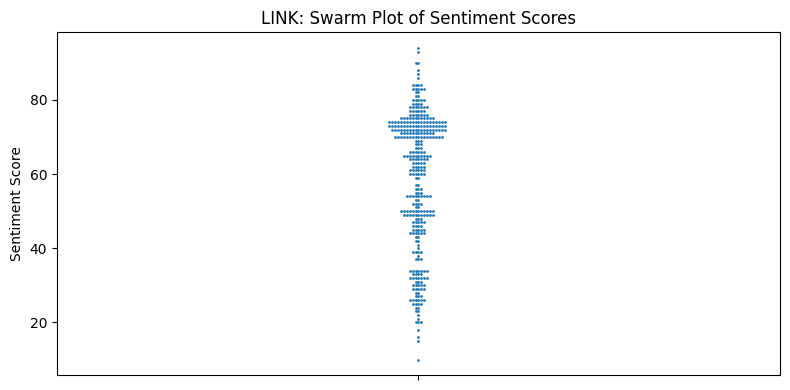

In [87]:
for coin in merged_df['coin'].unique():
    plt.figure(figsize=(8,4))
    sns.swarmplot(y=merged_df[merged_df['coin'] == coin]['sentiment_score'], size=2)
    plt.title(f'{coin}: Swarm Plot of Sentiment Scores')
    plt.ylabel('Sentiment Score')
    plt.tight_layout()
    plt.show()

The swarm plot displays all the individual sentiment scores for each coin, stacking similar values side by side. This lets us see where sentiment scores are clustered, spot any common mood patterns, and notice any unusual or outlier values for the market mood of each coin.

### Feature Engineering

In [88]:
# Sort just by coin (assuming within each coin, the data is in time order)
merged_df = merged_df.sort_values(['coin']).reset_index(drop=True)

# Daily Return: Percent change in closing price from previous day (per coin)
merged_df['daily_return'] = merged_df.groupby('coin')['close'].pct_change()

# 3-day Rolling Mean of Closing Price (per coin)
merged_df['close_ma3'] = merged_df.groupby('coin')['close'].rolling(3).mean().reset_index(level=0, drop=True)

# Price Direction: 1 if today's close > yesterday's, 0 otherwise (per coin)
merged_df['price_direction'] = merged_df.groupby('coin')['close'].diff().gt(0).astype(int)

# Preview the new features for the first 10 rows of each coin
print(merged_df[['coin', 'close', 'daily_return', 'close_ma3', 'price_direction']].groupby('coin').head(10))

       coin         close  daily_return      close_ma3  price_direction
0       BTC  106159.26000           NaN            NaN                0
1       BTC   96625.29000     -0.089808            NaN                0
2       BTC   97509.03000      0.009146  100097.860000                1
3       BTC   96119.88000     -0.014246   96751.400000                0
4       BTC   95781.80000     -0.003517   96470.236667                0
5       BTC   95607.40000     -0.001821   95836.360000                0
6       BTC   96632.03000      0.010717   96007.076667                1
7       BTC   98347.20000      0.017749   96862.210000                1
8       BTC   96157.03000     -0.022270   97045.420000                0
9       BTC   96582.12000      0.004421   97028.783333                1
350    DOGE       0.15589           NaN            NaN                0
351    DOGE       0.15471     -0.007569            NaN                0
352    DOGE       0.15730      0.016741       0.155967          

To improve our ability to predict future closing prices for each cryptocurrency, we engineered several new features for every coin in the dataset:

- **Daily Return:** The percent change in closing price from the previous day. This helps capture the momentum and volatility of each coin.
- **3-Day Rolling Mean of Close:** The average closing price over the current and previous two days. This smooths out short-term fluctuations and reveals recent trends.
- **Price Direction:** A simple binary indicator showing if today’s closing price is higher than yesterday’s (`1` for up, `0` for same or down). This can be useful for classification models or for understanding price momentum.

These features were calculated separately for each coin, so the relationships are not mixed across different assets. With these new columns, our dataset is now better prepared for both exploratory analysis and building predictive models.


### Comprehensive Data Analysis

#### 1. Normality test on daily returns

BTC: Shapiro-Wilk Test p-value = 0.0000 (n=349)


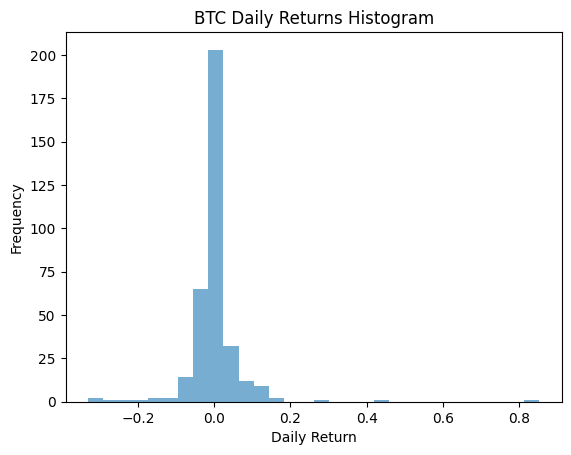

DOGE: Shapiro-Wilk Test p-value = 0.0000 (n=349)


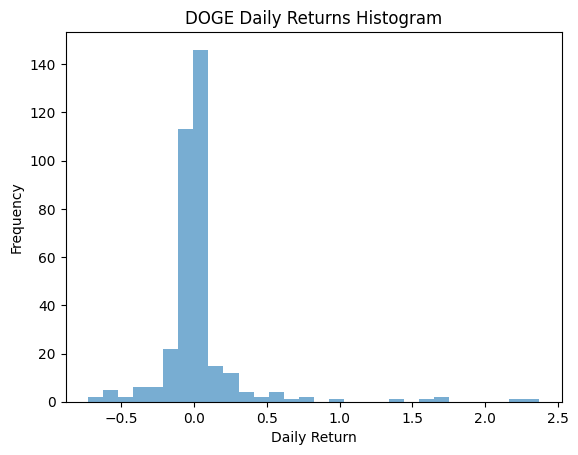

ETH: Shapiro-Wilk Test p-value = 0.0000 (n=349)


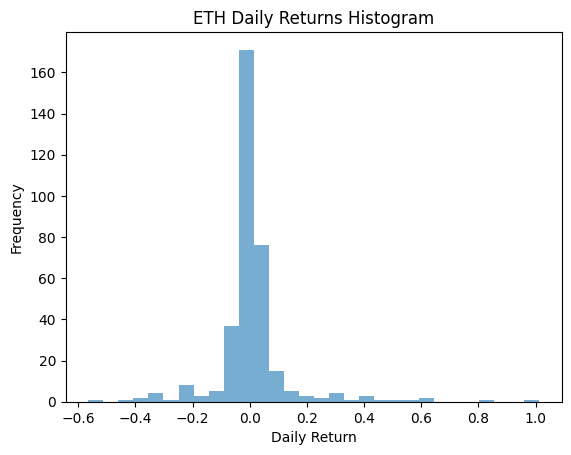

LINK: Shapiro-Wilk Test p-value = 0.0000 (n=349)


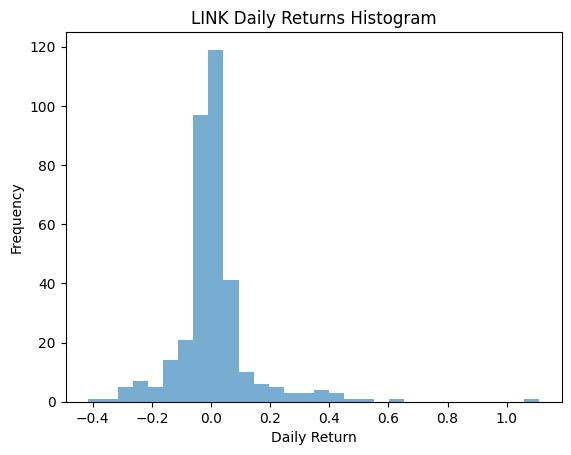

TRUMP: Shapiro-Wilk Test p-value = 0.0000 (n=199)


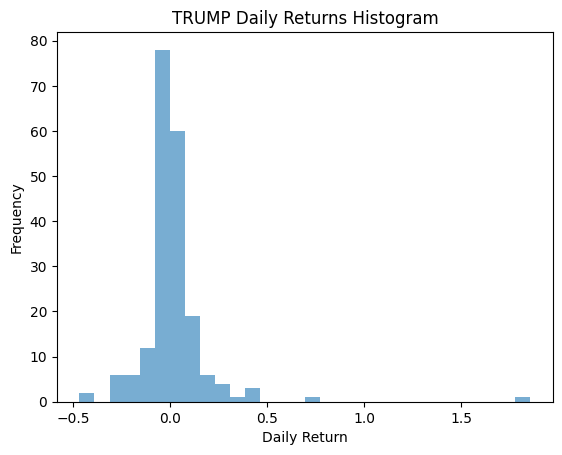

In [89]:
for coin in merged_df['coin'].unique():
    returns = merged_df[merged_df['coin'] == coin]['daily_return'].dropna()
    stat, p = shapiro(returns)
    print(f"{coin}: Shapiro-Wilk Test p-value = {p:.4f} (n={len(returns)})")
    plt.hist(returns, bins=30, alpha=0.6, label=coin)
    plt.title(f"{coin} Daily Returns Histogram")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.show()

Most cryptocurrencies' returns are not normally distributed (p < 0.05), which is typical and suggests classic linear models may not be fully appropriate.



#### 2. T-Test: comparing daily returns accross coins

In [90]:
coins = merged_df['coin'].unique()

print("T-Test: Pairwise Comparison of Daily Returns for All Coins\n")
for coin1, coin2 in itertools.combinations(coins, 2):
    returns1 = merged_df[merged_df['coin'] == coin1]['daily_return'].dropna()
    returns2 = merged_df[merged_df['coin'] == coin2]['daily_return'].dropna()
    t_stat, t_p = ttest_ind(returns1, returns2, equal_var=False)
    print(f"{coin1} vs {coin2}: p-value = {t_p:.4f}")

T-Test: Pairwise Comparison of Daily Returns for All Coins

BTC vs DOGE: p-value = 0.0555
BTC vs ETH: p-value = 0.4368
BTC vs LINK: p-value = 0.4603
BTC vs TRUMP: p-value = 0.5034
DOGE vs ETH: p-value = 0.1555
DOGE vs LINK: p-value = 0.1437
DOGE vs TRUMP: p-value = 0.2776
ETH vs LINK: p-value = 0.9578
ETH vs TRUMP: p-value = 0.8619
LINK vs TRUMP: p-value = 0.8319




We performed independent t-tests to compare the average daily returns between every possible pair of coins in our dataset. This helps us identify which coins have significantly different return profiles from each other. Low p-values (<0.05) indicate statistically significant differences in mean daily returns between those pairs.


#### 3. ANOVA

In [91]:
returns_by_coin = [merged_df[merged_df['coin'] == coin]['daily_return'].dropna() for coin in coins]
anova_stat, anova_p = f_oneway(*returns_by_coin)
print(f"\nANOVA F-test (All Coins): p-value = {anova_p:.4f}")


ANOVA F-test (All Coins): p-value = 0.1808


We used a one-way ANOVA to test if at least one coin's average daily returns are significantly different from the others. A low p-value (<0.05) means that not all coins have the same return behavior, which is important for understanding how $TRUMP compares with other cryptocurrencies in terms of risk and reward.

A low p-value (<0.05) means at least one coin's returns are statistically different from the others.

#### 4. Chi-Square Test: Up/Down Days

In [92]:
contingency = pd.crosstab(merged_df['coin'], merged_df['price_direction'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-Square test p-value = {p:.4f}")

print(contingency)

Chi-Square test p-value = 0.8598
price_direction    0    1
coin                     
BTC              183  167
DOGE             170  180
ETH              178  172
LINK             181  169
TRUMP            105   95


### Data Preprocessing

#### 1. Handling the Missing Values

In [93]:
# Fill missing values in your engineered features using linear interpolation, coin by coin
feature_cols = ['close', 'close_ma3', 'daily_return', 'price_direction']  

for coin in merged_df['coin'].unique():
    coin_mask = merged_df['coin'] == coin
    merged_df.loc[coin_mask, feature_cols] = merged_df.loc[coin_mask, feature_cols].interpolate(method='linear', limit_direction='both')
    
print(merged_df[feature_cols].isnull().sum())


close              0
close_ma3          0
daily_return       0
price_direction    0
dtype: int64


To ensure our dataset is complete and suitable for modeling, we addressed missing values in our engineered features (`close_ma3`, `daily_return`, and `price_direction`) by using linear interpolation. Instead of dropping rows with missing data—which would reduce the size of our dataset—we filled each missing value with the average of the previous and next valid entry for that feature, treating each coin separately.

This approach helps us keep as much historical data as possible while maintaining the natural sequence of price movements. Interpolation is especially useful for time series data like cryptocurrency prices, as it avoids introducing bias or artificial discontinuities that could occur if we simply removed incomplete rows.


#### 2. Feature Scaling

In [94]:
feature_cols = ['close', 'close_ma3', 'daily_return']
coins = merged_df['coin'].unique()

scaled_features = {}

for coin in coins:
    coin_df = merged_df[merged_df['coin'] == coin].copy()
    scaler = StandardScaler()
    scaled = scaler.fit_transform(coin_df[feature_cols])
    scaled_features[coin] = pd.DataFrame(scaled, columns=feature_cols, index=coin_df.index)

    print(f"{coin}: features scaled. Mean (should be ~0):", scaled_features[coin].mean().round(2).to_dict())


BTC: features scaled. Mean (should be ~0): {'close': -0.0, 'close_ma3': -0.0, 'daily_return': 0.0}
DOGE: features scaled. Mean (should be ~0): {'close': 0.0, 'close_ma3': 0.0, 'daily_return': 0.0}
ETH: features scaled. Mean (should be ~0): {'close': -0.0, 'close_ma3': 0.0, 'daily_return': -0.0}
LINK: features scaled. Mean (should be ~0): {'close': -0.0, 'close_ma3': -0.0, 'daily_return': 0.0}
TRUMP: features scaled. Mean (should be ~0): {'close': 0.0, 'close_ma3': -0.0, 'daily_return': -0.0}


#### 3. Splitting the merged_df into seperate ones again

In [95]:
coin_dfs = {}

for coin in merged_df['coin'].unique():
    coin_dfs[coin] = merged_df[merged_df['coin'] == coin].reset_index(drop=True)

print("Separated DataFrames for each coin:")
print("TRUMP:")
print(coin_dfs['TRUMP'].head())
print("BTC: ")
print(coin_dfs['BTC'].head())
print("ETH: ")
print(coin_dfs['ETH'].head())
print("LINK: ")
print(coin_dfs['LINK'].head())
print("DOGE: ")
print(coin_dfs['DOGE'].head())

Separated DataFrames for each coin:
TRUMP:
         date   open   high    low  close       volume   coin  \
0  2025-05-30  11.95  12.01  10.69  10.84  1620649.404  TRUMP   
1  2025-06-05  10.80  10.99   9.37   9.73  2101894.631  TRUMP   
2  2025-06-04  11.19  11.26  10.74  10.81   848073.907  TRUMP   
3  2025-06-01  11.25  11.42  10.95  11.39   489002.937  TRUMP   
4  2025-06-02  11.38  11.41  11.04  11.33   537700.749  TRUMP   

   sentiment_score sentiment_label  daily_return  close_ma3  price_direction  
0             60.0           Greed     -0.102399  10.460000                0  
1             57.0           Greed     -0.102399  10.460000                0  
2             62.0           Greed      0.110997  10.460000                1  
3             56.0           Greed      0.053654  10.643333                1  
4             64.0           Greed     -0.005268  11.176667                0  
BTC: 
         date       open       high        low      close        volume coin  \
0  202

Why We Split the Dataset by Coin?

In this project, we’re building separate predictive models for each cryptocurrency (TRUMP, BTC, DOGE, ETH, LINK, etc.). Splitting the dataset by coin ensures that each model is trained and tested using only the historical data for that specific asset. We only merged them in order to make it more easy for the EDA, feature engineering and preprocessing. We only dealt with one dataframe instead of 5. This is important for several reasons:

- **Prevents Data Leakage:** Combining data from multiple coins could let information from one coin accidentally influence the prediction of another, leading to unrealistic results.
- **Captures Unique Patterns:** Each coin behaves differently and may respond to market events in its own way. By keeping the data separate, each model can learn the unique trends, volatility, and behaviors of its specific coin.
- **Realistic Deployment:** In real-world use, we would typically want to predict future prices for one coin at a time, using only that coin’s data—not information from unrelated assets.

For these reasons, we’ve created individual datasets for each coin. Each dataset will be used to train, validate, and test a dedicated model for that asset, making our analysis more accurate and meaningful.


### Why Dimensionality Reduction (PCA) Is Not Relevant for This Project

Although dimensionality reduction techniques like Principal Component Analysis (PCA) are widely used in many machine learning and data science applications, they are not a good fit for our project. In our case, we have only a handful of well-chosen, meaningful features for each coin—such as closing price, daily return, and moving averages. These features are already directly interpretable and designed to capture the specific behaviors we care about.

Applying PCA or similar methods here would actually make our features harder to interpret, since principal components are mathematical combinations of the original variables and lose the intuitive meaning (like "close price" or "daily return") that is important for financial modeling. Furthermore, reducing the dimensions when there are only a few features to begin with could actually remove valuable information and hurt model performance, rather than improve it.

In summary, PCA and dimensionality reduction are not relevant or helpful for this particular problem. Keeping our feature set transparent and focused is both more practical and more informative for modeling and interpretation in cryptocurrency price prediction.
 